In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab
import mysql.connector as sql
import geopandas as gpd
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from feature_engine.categorical_encoders import MeanCategoricalEncoder
from feature_engine import missing_data_imputers as mdi

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [113]:
#df = pd.read_csv('Data/house_data_details_eda.csv')
#points = df.apply(lambda row: Point(row.longitude, row.latitude), axis=1) #Changing long and lat into shape
#gdf = gpd.GeoDataFrame(df, geometry=points)
#gdf.crs = {'init': 'epsg:4326'}
#gdf.head()
#gdf.plot()

In [84]:
#db_connection = sql.connect(host='Samuels-MacBook-Air.local', database='realestate_AVM',
#                            user='root', password='Building9Floor')

In [85]:
#df = pd.read_sql('SELECT * FROM properties;', con=db_connection)
#df.head()

In [150]:
raw_data = pd.read_csv('Data/house_data_details_eda.csv')
df = raw_data.copy()
df.head()

,latitude,longitude,address,property_type,home_size,lot_size,year_built,parcel_number,realtyID,county,subdivision,census,tract,lot,zoning,date,sale_price,estimated_value,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school quality,url,bedrooms,bathrooms,month
0,-118.44562,34.41838,17902 Stillmore St,Single Family Residence,1196.00000,7867.00000,1961.00000,2844008001,1111559154.00000,Los Angeles,25916,1.00000,920039.00000,6,SCUR2,2020-10-09,417000.00000,568700.00000,1,Low,6,1,Excellent,https://www.realtytrac.com/property/ca/santa-c...,3.00000,2.00000,2020-10
1,-118.34000,34.17455,2805 W Chandler Blvd,Single Family Residence,950.00000,2750.00000,1954.00000,2478008002,1111549760.00000,Los Angeles,9852,2.00000,311300.00000,52,BUR1*,2020-10-09,770000.00000,684100.00000,4,Low,5,1,Above Average,https://www.realtytrac.com/property/ca/burbank...,2.00000,1.00000,2020-10
2,-118.38114,33.81235,280 Via Linda Vis,Single Family Residence,2029.00000,7007.00000,1948.00000,7514018019,1111567119.00000,Los Angeles,10302,4.00000,651304.00000,19,TORR-LO,2020-10-09,1250000.00000,1437000.00000,3,Low,3,2,Excellent,https://www.realtytrac.com/property/ca/redondo...,2.00000,2.00000,2020-10
3,-117.99154,33.99928,14852 Edgeridge Dr,Single Family Residence,3046.00000,51836.40000,1949.00000,8221018031,1111565735.00000,Los Angeles,2610,2.00000,408402.00000,13,LCA110000*,2020-10-09,1225000.00000,1061000.00000,0,Moderate,2,1,Above Average,https://www.realtytrac.com/property/ca/haciend...,3.00000,2.00000,2020-10
4,-117.99388,34.07099,12844 Waltham St,Single Family Residence,1080.00000,12251.00000,1947.00000,8556005010,1111564332.00000,Los Angeles,10104,3.00000,404701.00000,283,BPR1*,2020-10-09,480000.00000,558900.00000,4,Moderate,3,1,Average,https://www.realtytrac.com/property/ca/baldwin...,3.00000,1.00000,2020-10


In [151]:
features = ['latitude', 'longitude', 'home_size', 'lot_size', 'property_type', 'crime_index', 'school quality', 'month']

targets = df['sale_price']
inputs = df[features]

In [152]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=.2, random_state=24)

In [153]:
#Encode the categorical variable by the mean sale price of each category
mean_enc = MeanCategoricalEncoder(variables=['property_type', 'crime_index', 'month', 'school quality'])
mean_enc.fit(x_train, y_train)

x_train = mean_enc.transform(x_train)
x_test = mean_enc.transform(x_test)

#Impute the missing values for month
imputer = mdi.EndTailImputer(distribution='skewed', tail='left')
imputer.fit(x_train)

x_test = imputer.transform(x_test)

In [147]:
def diagnostic_plots(df, variable, labels):
    
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    df[variable].hist()
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist='norm', plot=pylab)
    plt.title(col)
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1,3,3)
    plt.scatter(df[variable], labels)
    plt.title(col)
    plt.ticklabel_format(style='plain', axis='x')

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=features)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=features)

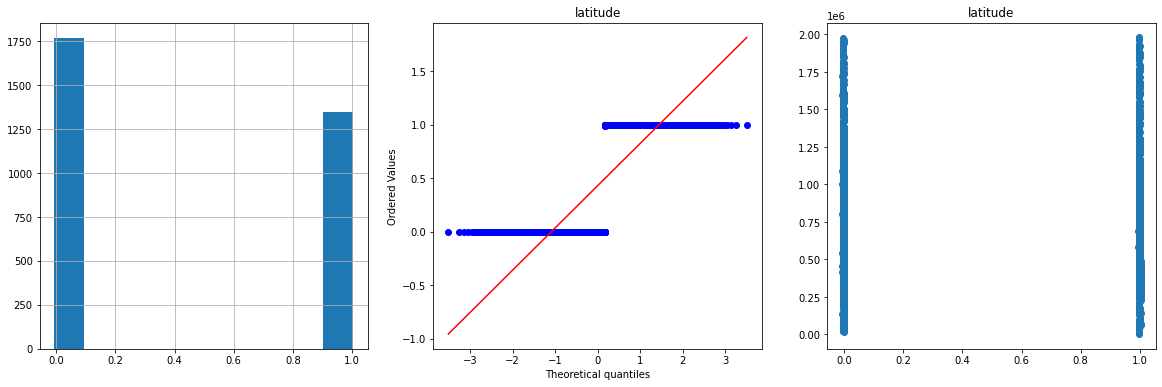

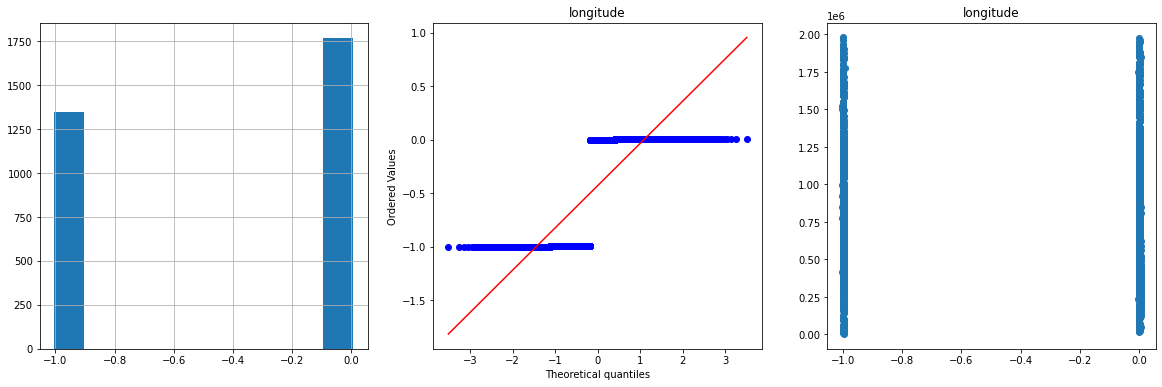

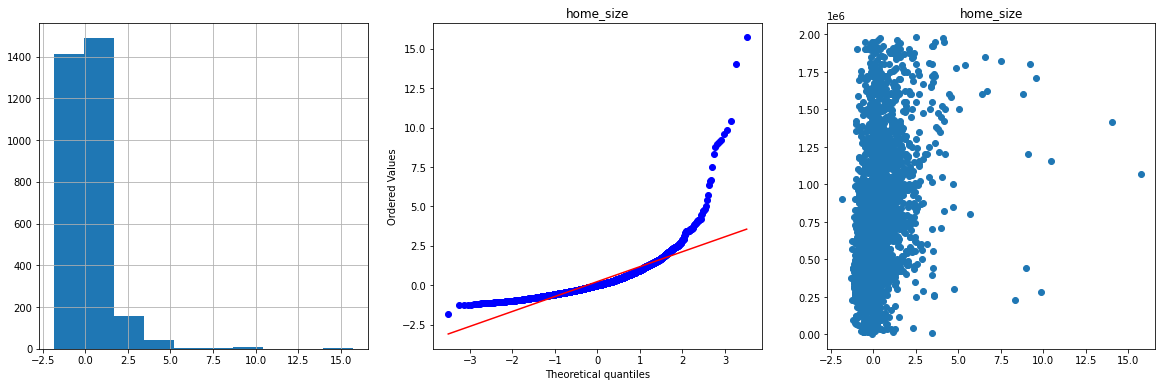

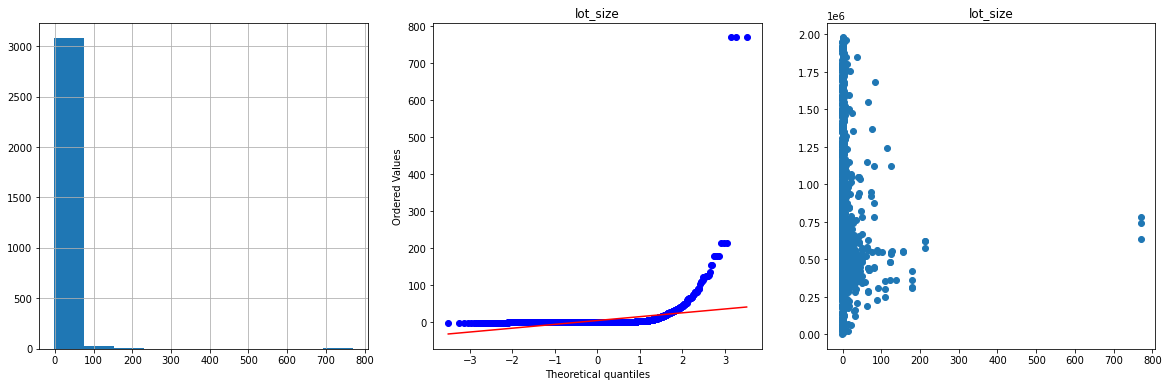

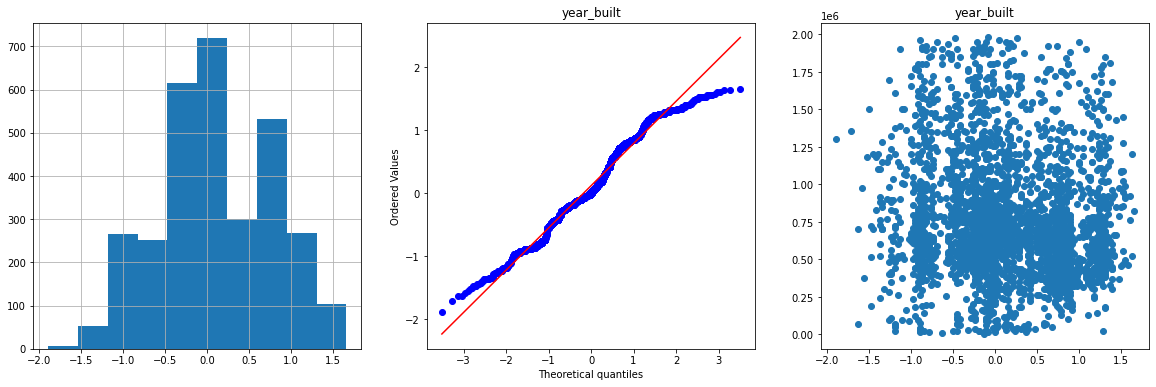

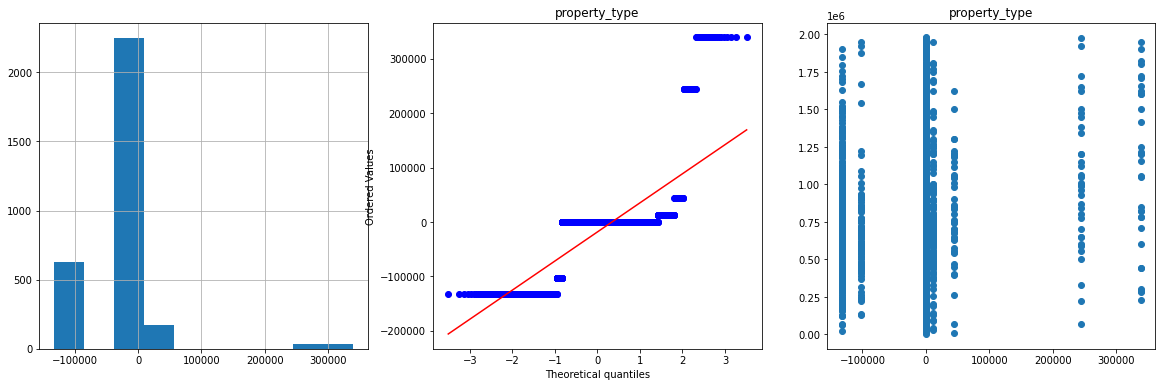

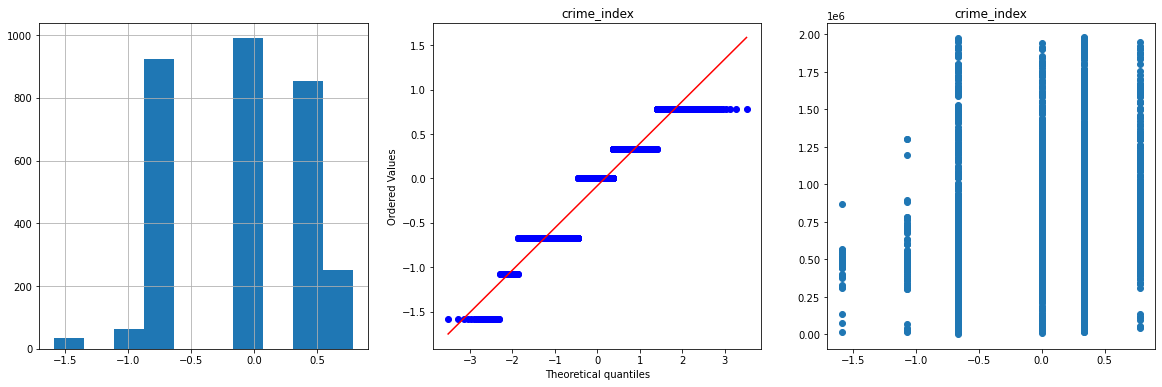

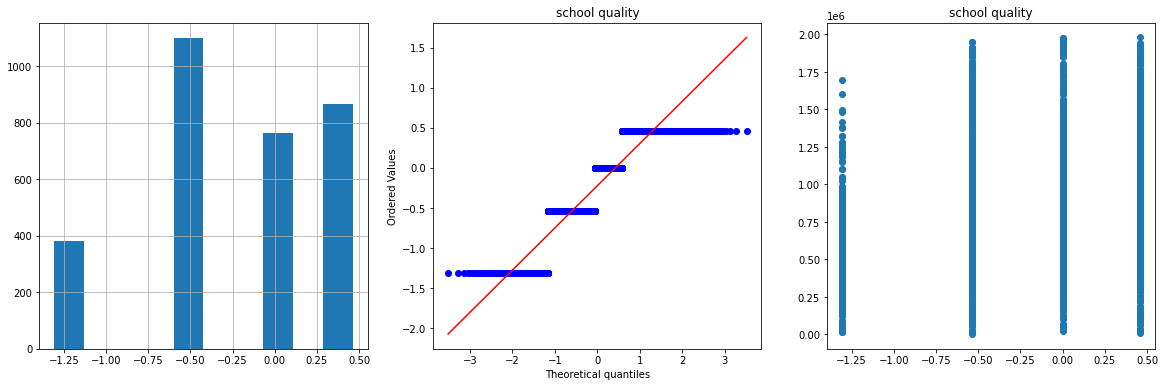

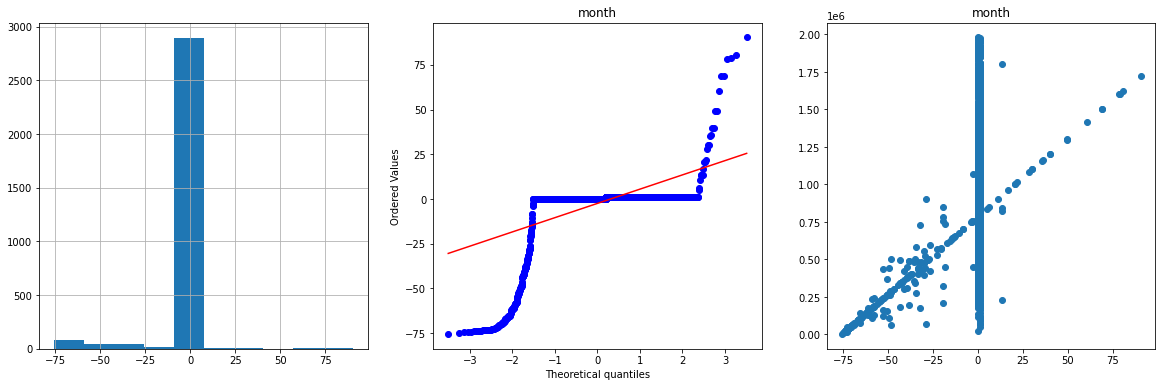

In [149]:
for col in x_train_scaled.columns:
    diagnostic_plots(x_train_scaled, col, y_train)

In [40]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

In [154]:
def acc_model(params):
    rf = RandomForestRegressor(**params)
    return cross_val_score(rf, x_train, y_train).mean()

param_space = {
    
               'n_estimators': hp.choice('n_estimators', range(25,500)), 
               'max_features': hp.choice('max_features',range(1,7)), 
               'min_samples_leaf': hp.choice('min_samples_leaf',range(1,3))
            }

best = 0

def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

new best:                                              
0.7379044716327353                                     
{'max_features': 5, 'min_samples_leaf': 1, 'n_estimators': 435}
new best:                                                                        
0.7382547358039784                                                               
{'max_features': 6, 'min_samples_leaf': 1, 'n_estimators': 305}                  
new best:                                                                        
0.7391989304637056                                                               
{'max_features': 6, 'min_samples_leaf': 1, 'n_estimators': 367}                  
new best:                                                                        
0.7391989304637056                                                               
{'max_features': 4, 'min_samples_leaf': 2, 'n_estimators': 299}                  
new best:                                                                        
0.73

new best:                                                                         
0.7391989304637056                                                                
{'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 320}                   
new best:                                                                         
0.7391989304637056                                                                
{'max_features': 1, 'min_samples_leaf': 1, 'n_estimators': 293}                   
new best:                                                                         
0.7391989304637056                                                                
{'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 174}                   
new best:                                                                         
0.7391989304637056                                                                
{'max_features': 1, 'min_samples_leaf': 2, 'n_estimators': 280}                   
new 

{'max_features': 1, 'min_samples_leaf': 2, 'n_estimators': 58}                    
new best:                                                                         
0.7395504818904063                                                                
{'max_features': 1, 'min_samples_leaf': 2, 'n_estimators': 377}                   
new best:                                                                         
0.7395504818904063                                                                
{'max_features': 1, 'min_samples_leaf': 2, 'n_estimators': 432}                   
new best:                                                                         
0.7395504818904063                                                                
{'max_features': 1, 'min_samples_leaf': 2, 'n_estimators': 427}                   
new best:                                                                         
0.7395504818904063                                                                
{'ma

0.7395504818904063                                                                
{'max_features': 6, 'min_samples_leaf': 2, 'n_estimators': 436}                   
new best:                                                                         
0.7395504818904063                                                                
{'max_features': 4, 'min_samples_leaf': 2, 'n_estimators': 156}                   
100%|██████████| 100/100 [13:58<00:00,  8.38s/trial, best loss: 0.6665842182785949]
best:
{'max_features': 0, 'min_samples_leaf': 1, 'n_estimators': 6}


In [155]:
rf = RandomForestRegressor(n_estimators=156, 
                           max_features=4,
                           min_samples_leaf=2,
                           random_state=24)

rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
score = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Random Forest Score score: {score}')

Random Forest Score score: 254067.61972395374


In [156]:
lr = LinearRegression()
lr.fit(x_train_scaled, y_train)
predictions = lr.predict(x_test_scaled)
score = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Linear Regression score: {score}')

Linear Regression score: 312406.2253480721
